In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

In [2]:
# Creando Arquitectura 
learning_rate = 0.0001
seq_len = 50
max_epochs = 25
hidden_dim = 100
output_dim = 1
bptt_truncate = 5 # Iteraciones Backpropagation
min_clip_val = -10
max_clip_val = 10

In [3]:
# Función de Activación 
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [4]:
def calculate_loss(X, Y, U, V, W):
    loss = 0.0
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]
        prev_activation = np.zeros((hidden_dim, 1)) # valores anteriores
        for timestep in range(seq_len):
            new_input = np.zeros(x.shape) # Nueva entrada en cada iteracion 
            new_input[timestep] = x[timestep] 
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_activation)
            _sum = mulu + mulw
            activation = sigmoid(_sum)
            mulv = np.dot(V, activation)
            prev_activation = activation
        # calculo del error
        loss_per_record = float((y - mulv)**2/2)
        loss += loss_per_record
    return loss, activation

In [5]:
# Toma los valores de x y las matrices de pesos
# Regresa un diccionario con los pesos finales (mulu, mulw, mulv)
def calc_layers(x, U, V, W, prev_activation):
    layers = []
    for timestep in range(seq_len):
        new_input = np.zeros(x.shape)
        new_input[timestep] = x[timestep]
        mulu = np.dot(U, new_input)
        mulw = np.dot(W, prev_activation)
        _sum = mulw + mulu
        activation = sigmoid(_sum)
        mulv = np.dot(V, activation)
        layers.append({'activation': activation, 'prev_activation': prev_activation})
        prev_activation = activation
 
    return layers, mulu, mulw, mulv

In [6]:
def backprop(x, U, V, W, dmulv, mulu, mulw, layers):
    dU = np.zeros(U.shape)
    dV = np.zeros(V.shape)
    dW = np.zeros(W.shape)
   
    dU_t = np.zeros(U.shape)
    dV_t = np.zeros(V.shape)
    dW_t = np.zeros(W.shape)
   
    dU_i = np.zeros(U.shape)
    dW_i = np.zeros(W.shape)
   
    _sum = mulu + mulw
    dsv = np.dot(np.transpose(V), dmulv)
   
    def get_previous_activation_differential(_sum, ds, W):
        d_sum = _sum * (1 - _sum) * ds
        dmulw = d_sum * np.ones_like(ds)
        return np.dot(np.transpose(W), dmulw)
   
    for timestep in range(seq_len):
        dV_t = np.dot(dmulv, np.transpose(layers[timestep]['activation']))
        ds = dsv
        dprev_activation = get_previous_activation_differential(_sum, ds, W)
       
        for _ in range(timestep-1, max(-1, timestep-bptt_truncate-1), -1):
            ds = dsv + dprev_activation
            dprev_activation = get_previous_activation_differential(_sum, ds, W)
            dW_i = np.dot(W, layers[timestep]['prev_activation'])
           
            new_input = np.zeros(x.shape)
            new_input[timestep] = x[timestep]
            dU_i = np.dot(U, new_input)
           
            dU_t += dU_i
            dW_t += dW_i
           
        dU += dU_t
        dV += dV_t
        dW += dW_t
       
        # Verificacion de Limites
        if dU.max() > max_clip_val:
            dU[dU > max_clip_val] = max_clip_val
        if dV.max() > max_clip_val:
            dV[dV > max_clip_val] = max_clip_val
        if dW.max() > max_clip_val:
            dW[dW > max_clip_val] = max_clip_val
       
        if dU.min() < min_clip_val:
            dU[dU < min_clip_val] = min_clip_val
        if dV.min() < min_clip_val:
            dV[dV < min_clip_val] = min_clip_val
        if dW.min() < min_clip_val:
            dW[dW < min_clip_val] = min_clip_val
       
    return dU, dV, dW

In [7]:
# Entrenamiento
def train(U, V, W, X, Y, X_validation, Y_validation):
    for epoch in range(max_epochs):
        # Calculo inicial de perdidas
        loss, prev_activation = calculate_loss(X, Y, U, V, W)
 
        # Perdidas de Validacion 
        val_loss, _ = calculate_loss(X_validation, Y_validation, U, V, W)
       
        print(f'Epoch: {epoch+1}, Loss: {loss}, Validation Loss: {val_loss}')
 
        # Entrenamiento calculo frontal
        for i in range(Y.shape[0]):
            x, y = X[i], Y[i]
            layers = []
            prev_activation = np.zeros((hidden_dim, 1))
           
            layers, mulu, mulw, mulv = calc_layers(x, U, V, W, prev_activation)
               
            # diferencia de la prediccion
            dmulv = mulv - y
            dU, dV, dW = backprop(x, U, V, W, dmulv, mulu, mulw, layers)
           
            # actualizacion de pesos 
            U -= learning_rate * dU
            V -= learning_rate * dV
            W -= learning_rate * dW
    return U, V, W

In [8]:
sin_wave = np.array([math.sin(x) for x in range(200)])
# Datos de entrenamiento
X = []
Y = []
num_records = len(sin_wave) - seq_len # 150
 
for i in range(num_records-50):
    X.append(sin_wave[i:i+seq_len])
    Y.append(sin_wave[i+seq_len])
 
X = np.expand_dims(np.array(X), axis=2) # 100 x 50 x 1
Y = np.expand_dims(np.array(Y), axis=1) # 100 x 1
 
# Datos de validacion 
X_validation = []
Y_validation = []
for i in range(num_records-seq_len, num_records):
    X_validation.append(sin_wave[i:i+seq_len])
    Y_validation.append(sin_wave[i+seq_len])
 
X_validation = np.expand_dims(np.array(X_validation), axis=2)
Y_validation = np.expand_dims(np.array(Y_validation), axis=1)

In [9]:
np.random.seed(12161)
U = np.random.uniform(0, 1, (hidden_dim, seq_len)) # Pesos acapa oculta
V = np.random.uniform(0, 1, (output_dim, hidden_dim)) # Pesos a capa de salida 
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim)) # pesos para capa recurrente

In [10]:
U, V, W = train(U, V, W, X, Y, X_validation, Y_validation)

Epoch: 1, Loss: 132219.50990086797, Validation Loss: 66107.73179592531
Epoch: 2, Loss: 85800.72307067864, Validation Loss: 42898.72415489228
Epoch: 3, Loss: 49381.93624027209, Validation Loss: 24689.716513750416
Epoch: 4, Loss: 22963.14709973055, Validation Loss: 11480.70771518648
Epoch: 5, Loss: 6528.960175424226, Validation Loss: 3263.9837277981487
Epoch: 6, Loss: 73.43771584553774, Validation Loss: 36.6254559307141
Epoch: 7, Loss: 35.56509269212909, Validation Loss: 17.718053646170077
Epoch: 8, Loss: 35.07918252929785, Validation Loss: 17.47095514195891
Epoch: 9, Loss: 35.23614413947865, Validation Loss: 17.546993666296256
Epoch: 10, Loss: 35.75376997444873, Validation Loss: 17.802592395366606
Epoch: 11, Loss: 34.72350197542023, Validation Loss: 17.295445402866676
Epoch: 12, Loss: 34.81698751405845, Validation Loss: 17.339911966262136
Epoch: 13, Loss: 35.08009594916389, Validation Loss: 17.47401532953728
Epoch: 14, Loss: 34.901820930981174, Validation Loss: 17.385375591432396
Epoch:

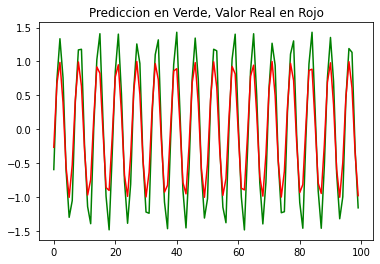

In [11]:
# prediccion con datos de entrenamiento
predictions = []
for i in range(Y.shape[0]):
    x, y = X[i], Y[i]
    prev_activation = np.zeros((hidden_dim,1))
    for timestep in range(seq_len):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_activation)
        _sum = mulu + mulw
        activation = sigmoid(_sum)
        mulv = np.dot(V, activation)
        prev_activation = activation
    predictions.append(mulv)
 
predictions = np.array(predictions)
 
plt.plot(predictions[:, 0,0], 'g')
plt.plot(Y[:, 0], 'r')
plt.title("Prediccion en Verde, Valor Real en Rojo")
plt.show()

In [12]:
rmse = math.sqrt(mean_squared_error(Y[:,0], predictions[:, 0, 0]))
print(rmse)

0.33478452092882743


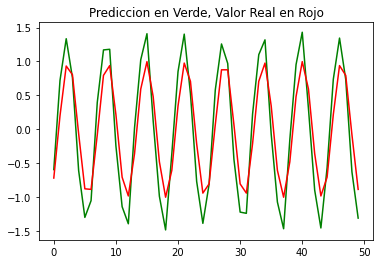

In [13]:
# prediccion con datos de validacion
val_predictions = []
for i in range(Y_validation.shape[0]):
    x, y = X[i], Y[i]
    prev_activation = np.zeros((hidden_dim,1))
    # forward pass
    for timestep in range(seq_len):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_activation)
        _sum = mulu + mulw
        activation = sigmoid(_sum)
        mulv = np.dot(V, activation)
        prev_activation = activation
    val_predictions.append(mulv)
 
val_predictions = np.array(val_predictions)
 
plt.plot(val_predictions[:, 0,0], 'g')
plt.plot(Y_validation[:, 0], 'r')
plt.title("Prediccion en Verde, Valor Real en Rojo")
plt.show()

In [14]:
# Calculode RMSE
rmse = math.sqrt(mean_squared_error(Y_validation[:,0], val_predictions[:, 0, 0]))
print(rmse)

0.4032936897958309
